In [ ]:
from collections import Counter, defaultdict
from itertools import combinations
import re
import random
import numpy as np
import math
from typing import Tuple
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kendalltau

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state

from lightgbm import LGBMClassifier, early_stopping

In [3]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
df_features = pd.read_csv("train_set_10.4k.csv", index_col=0)

In [5]:
np.random.seed(42)
random.seed(42)

In [6]:
y = df_features['pathogenicity_label'].astype(int)
X = df_features.drop(columns=['pathogenicity_label'])
print(f"Shape of X (features) is: {X.shape}")
print(f"Shape of y (target) is: {y.shape}")

Shape of X (features) is: (10370, 973)
Shape of y (target) is: (10370,)


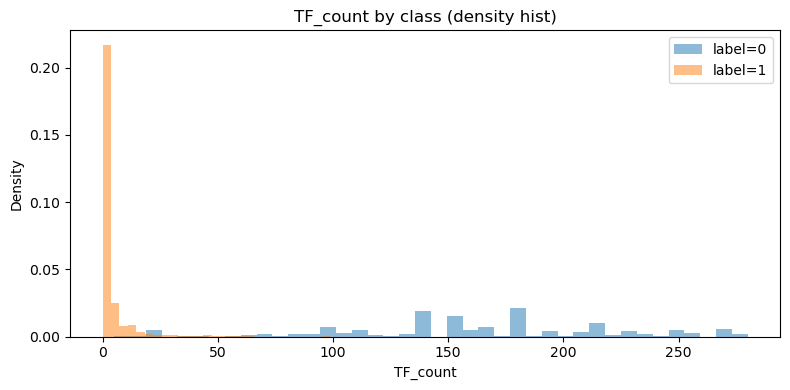

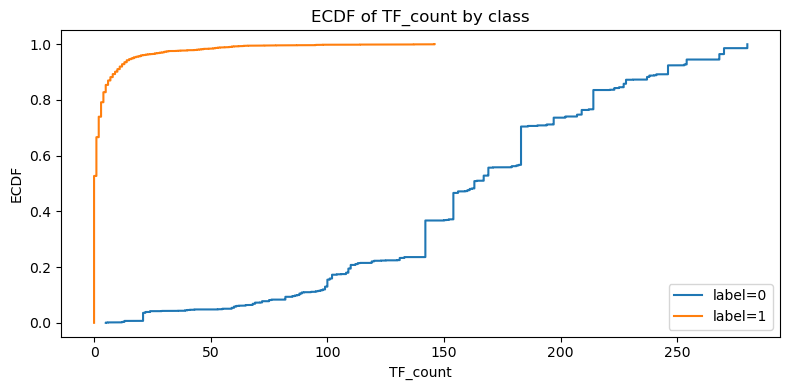

AUC(TF_count only) = 0.003
Best threshold (Youden J): inf  -> TPR=0.000, FPR=0.000
Confusion matrix @ best threshold (rows=true, cols=pred):
 [[5071    0]
 [5299    0]]
              precision    recall  f1-score   support

           0      0.489     1.000     0.657      5071
           1      0.000     0.000     0.000      5299

    accuracy                          0.489     10370
   macro avg      0.245     0.500     0.328     10370
weighted avg      0.239     0.489     0.321     10370


Top TF_has_* correlations with TF_count:
TF_has_MNT        0.905504
TF_has_HDAC1      0.899272
TF_has_NRF1       0.898893
TF_has_BHLHE40    0.897112
TF_has_SP1        0.894297
TF_has_MYC        0.893000
TF_has_IKZF1      0.891754
TF_has_YY1        0.889520
TF_has_JUND       0.886039
TF_has_MAX        0.882408
TF_has_EGR1       0.870439
TF_has_SIN3A      0.868865
TF_has_REST       0.867368
TF_has_ZBTB33     0.857753
TF_has_GABPA      0.833610
TF_has_CTCF       0.816029
TF_has_POLR2A     0.779701
TF_

/home/vincnet/miniconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vincnet/miniconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vincnet/miniconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

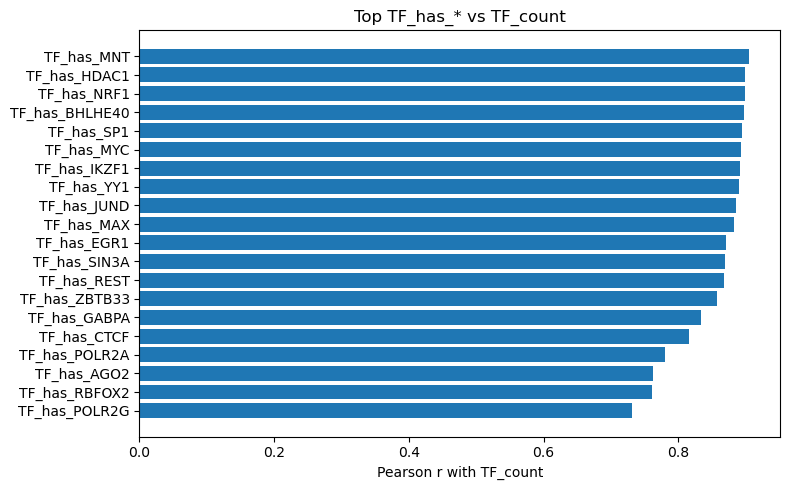

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

# Ensure TF_count is numeric
assert 'TF_count' in X.columns, "TF_count not found in X."
df = pd.DataFrame({'TF_count': pd.to_numeric(X['TF_count'], errors='coerce'),
                   'label': y.astype(int)})
df = df.dropna(subset=['TF_count']).copy()

# Histogram overlay
plt.figure(figsize=(8,4))
bins = 40
vals0 = df.loc[df.label==0, 'TF_count'].values
vals1 = df.loc[df.label==1, 'TF_count'].values
plt.hist(vals0, bins=bins, alpha=0.5, density=True, label='label=0')
plt.hist(vals1, bins=bins, alpha=0.5, density=True, label='label=1')
plt.xlabel("TF_count"); plt.ylabel("Density"); plt.title("TF_count by class (density hist)")
plt.legend(); plt.tight_layout(); plt.show()

# ECDF overlay (to see separation better)
def ecdf(a):
    a = np.sort(a)
    y = np.arange(1, len(a)+1) / len(a)
    return a, y

x0, y0 = ecdf(vals0)
x1, y1 = ecdf(vals1)
plt.figure(figsize=(8,4))
plt.step(x0, y0, where='post', label='label=0')
plt.step(x1, y1, where='post', label='label=1')
plt.xlabel("TF_count"); plt.ylabel("ECDF"); plt.title("ECDF of TF_count by class")
plt.legend(); plt.tight_layout(); plt.show()

# AUC using TF_count only + best threshold
scores = df['TF_count'].values
labels = df['label'].values
auc = roc_auc_score(labels, scores)
fpr, tpr, thr = roc_curve(labels, scores)
j = tpr - fpr
best_idx = np.argmax(j)
best_thr = thr[best_idx]
print(f"AUC(TF_count only) = {auc:.3f}")
print(f"Best threshold (Youden J): {best_thr:.3f}  -> TPR={tpr[best_idx]:.3f}, FPR={fpr[best_idx]:.3f}")

# Confusion matrix at best threshold
pred = (scores >= best_thr).astype(int)
cm = confusion_matrix(labels, pred, labels=[0,1])
print("Confusion matrix @ best threshold (rows=true, cols=pred):\n", cm)
print(classification_report(labels, pred, digits=3))

# Correlation between TF_count and TF_has_* features
tf_has_cols = [c for c in X.columns if c.startswith('TF_has_')]
if tf_has_cols:
    corrs = pd.Series({c: np.corrcoef(pd.to_numeric(X[c], errors='coerce').fillna(0).values,
                                      df['TF_count'].values)[0,1]
                       for c in tf_has_cols})
    corrs = corrs.sort_values(ascending=False)
    print("\nTop TF_has_* correlations with TF_count:")
    print(corrs.head(20).to_string())
    # quick bar plot
    top = corrs.head(20)
    plt.figure(figsize=(8, max(4, 0.25*len(top))))
    plt.barh(top.index[::-1], top.values[::-1])
    plt.xlabel("Pearson r with TF_count"); plt.title("Top TF_has_* vs TF_count")
    plt.tight_layout(); plt.show()
else:
    print("No TF_has_* columns found.")


### Because of TF features leaking the target label we remove them

In [8]:
X = X.drop(columns=['TF_count', 'TF_score_sum', 'TF_score_max', 'TF_score_mean', 'TF_score_min'])
X = X.drop(columns=tf_has_cols, errors='ignore')

In [9]:
def print_nan_columns(X: pd.DataFrame):
    na_cols = X.columns[X.isna().any()].tolist()
    if na_cols:
        counts = X[na_cols].isna().sum().sort_values(ascending=False)
        print(f"Columns with NaNs ({len(na_cols)}):")
        print(counts.to_string())
    else:
        print("No columns contain NaNs.")
    return na_cols

In [10]:
cat_cols = X.select_dtypes(include=["object", "string", "category", "bool"]).columns.tolist()
print(f"{len(cat_cols)} non-numeric columns found:")
for c in cat_cols:
    print(" -", c)

3 non-numeric columns found:
 - ss_class
 - rASA
 - is_synonymous


In [11]:
for c in cat_cols:
    vals = X[c].dropna().astype(str)
    nunq = vals.nunique()
    ex = ", ".join(vals.unique()[:5])
    print(f"{c}: {nunq} unique (example: {ex}{'...' if nunq>5 else ''})")

ss_class: 3 unique (example: Loop, Helix, Sheet)
rASA: 9 unique (example: E, -, P, H, T...)
is_synonymous: 1 unique (example: False)


In [12]:
X = X.drop(columns=[c for c in ["is_synonymous"] if c in X.columns]).copy()

In [51]:
X.shape

(10370, 947)

In [52]:
n_rows = len(X)

# Per-feature missingness
nan_count = X.isna().sum().rename("n_nan")
nan_pct   = (X.isna().mean() * 100).rename("pct_nan")
dtypes    = X.dtypes.rename("dtype")

nan_table = (
    pd.concat([nan_count, nan_pct, dtypes], axis=1)
      .query("n_nan > 0")                      # keep only columns that have NaNs
      .sort_values("pct_nan", ascending=False)
)

print(f"Rows: {n_rows}")
print(f"Rows with any NaN: {X.isna().any(axis=1).mean()*100:.2f}%")
nan_table

Rows: 10370
Rows with any NaN: 11.76%


,n_nan,pct_nan,dtype
sap_8,1190,11.475410,float64
sap_10,1190,11.475410,float64
sap_12,1190,11.475410,float64
sap_14,1190,11.475410,float64
plddt,1190,11.475410,float64
ss_class,1190,11.475410,object
rASA,1190,11.475410,object
phi,1190,11.475410,float64
psi,1190,11.475410,float64
global_plddt,1098,10.588235,float64


In [13]:
cat_cols = [c for c in ["ss_class", "rASA"] if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

In [ ]:
def make_knn_imputer_preprocessor(
    X: pd.DataFrame,
    n_neighbors: int = 5,
    weights: str = "uniform",
    metric: str = "nan_euclidean",
    scale_onehot: bool = False,
):
    # Identify columns
    cat_cols = [c for c in ["ss_class", "rASA"] if c in X.columns]
    num_cols = [c for c in X.columns if c not in cat_cols]

    # Numeric branch: KNN
    num_pipe = Pipeline([
        ("impute", KNNImputer(n_neighbors=n_neighbors, weights=weights, metric=metric)),
        ("scale", StandardScaler()),
    ])

    # Categorical branch: one-hot, dense, ignore unknowns
    cat_pipe = Pipeline([
        ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
        *([("scale", StandardScaler())] if scale_onehot else []),
    ])

    ct = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

    pp = Pipeline([("ct", ct)])
    pp.set_output(transform="pandas")
    return pp

In [ ]:
def create_feature_bags(df_columns):
    """
    Groups feature names into bags with regex and manual rules.
    """
    bags = defaultdict(list)
    pattern = re.compile(r'^(.*\D)(\d+)$')

    # Treat these as singletons (each in its own bag), even if they end with digits
    singleton_exceptions = {
        'esm2_delta_l1', 'esm2_delta_l2',
        # add more here if needed
    }

    # One-hot style prefixes to ignore (keep as singletons too)
    one_hot_prefixes_to_ignore = {
        'wt_mut_transition_chgpos'
    }

    manual_groups = {
        'TF_score': ['TF_score_min', 'TF_score_mean', 'TF_score_max', 'TF_score_sum'],
        'propy_AAComp': [
            'propy_A','propy_R','propy_N','propy_D','propy_C','propy_E','propy_Q','propy_G',
            'propy_H','propy_I','propy_L','propy_K','propy_M','propy_F','propy_P','propy_S',
            'propy_T','propy_W','propy_Y','propy_V'
        ],

    }
    manually_grouped_flat = {c for grp in manual_groups.values() for c in grp}

    for col in df_columns:
        # skip, will be added from manual groups later
        if col in manually_grouped_flat:
            continue

        # explicit singletons
        if col in singleton_exceptions:
            bags[col].append(col)
            continue

        # ignore certain one-hot prefixes -> singletons
        if any(col.startswith(prefix) for prefix in one_hot_prefixes_to_ignore):
            bags[col].append(col)
            continue

        # regex bagging
        m = pattern.match(col)
        if m:
            base = m.group(1).rstrip('_')
            bags[base].append(col)
        else:
            bags[col].append(col)

    # add manual groups
    for group_name, cols in manual_groups.items():
        exist = [c for c in cols if c in df_columns]
        if exist:
            bags[group_name].extend(exist)

    print(f"Identified {len(bags)} feature bags after refinement.")
    return bags


In [16]:
feature_bags = create_feature_bags(X)

Identified 101 feature bags after refinement.


In [17]:
feature_bags

defaultdict(list,
            {'sap': ['sap_8', 'sap_10', 'sap_12', 'sap_14'],
             'global_plddt': ['global_plddt'],
             'plddt': ['plddt'],
             'ss_class': ['ss_class'],
             'rASA': ['rASA'],
             'phi': ['phi'],
             'psi': ['psi'],
             'blosum': ['blosum45', 'blosum62', 'blosum80'],
             'grantham': ['grantham'],
             'phyloP100way_score': ['phyloP100way_score'],
             'phastCons100way_score': ['phastCons100way_score'],
             'propy__PolarizabilityC': ['propy__PolarizabilityC1',
              'propy__PolarizabilityC2',
              'propy__PolarizabilityC3'],
             'propy__SolventAccessibilityC': ['propy__SolventAccessibilityC1',
              'propy__SolventAccessibilityC2',
              'propy__SolventAccessibilityC3'],
             'propy__SecondaryStrC': ['propy__SecondaryStrC1',
              'propy__SecondaryStrC2',
              'propy__SecondaryStrC3'],
             'propy__Ch

In [18]:
def select_bag_representatives_pls(Xdf, y, bags, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    chosen = {}
    for bag, cols in bags.items():
        cols = [c for c in cols if c in Xdf.columns]
        if len(cols) == 0:
            continue
        if len(cols) == 1:
            chosen[bag] = cols[0]
            continue

        wins = Counter()
        for tr_idx, _ in skf.split(Xdf, y):
            Xtr = Xdf.iloc[tr_idx][cols].copy()
            ytr = y.iloc[tr_idx]

            # impute only using the TRAIN fold (no leakage)
            imp = KNNImputer(n_neighbors=5)
            Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=cols, index=Xtr.index)

            # guard: need at least 2 nonzero-variance cols
            keep_cols = Xtr_imp.columns[Xtr_imp.var() > 0]
            if len(keep_cols) < 2:
                wins[keep_cols[0] if len(keep_cols) else cols[0]] += 1
                continue

            pls = PLSRegression(n_components=1)
            pls.fit(Xtr_imp[keep_cols].values, ytr.values)
            load = np.abs(pls.x_weights_[:, 0])
            winner = keep_cols[int(np.argmax(load))]
            wins[winner] += 1

        chosen[bag] = wins.most_common(1)[0][0]
    return chosen

In [19]:
bag_reps = select_bag_representatives_pls(X, y, feature_bags, n_splits=5)
rep_cols = [bag_reps[b] for b in bag_reps.keys()]
df_reps_pls = X[rep_cols].copy()
print(f"PLS-selected representatives: {df_reps_pls.shape[1]} features.")

PLS-selected representatives: 101 features.


In [50]:
rep_cols

['sap_14',
 'global_plddt',
 'plddt',
 'ss_class',
 'rASA',
 'phi',
 'psi',
 'blosum80',
 'grantham',
 'phyloP100way_score',
 'phastCons100way_score',
 'propy__PolarizabilityC3',
 'propy__SolventAccessibilityC2',
 'propy__SecondaryStrC2',
 'propy__ChargeC3',
 'propy__PolarityC2',
 'propy__NormalizedVDWVC1',
 'propy__HydrophobicityC2',
 'propy__PolarizabilityT12',
 'propy__SolventAccessibilityT13',
 'propy__SecondaryStrT12',
 'propy__ChargeT13',
 'propy__PolarityT13',
 'propy__NormalizedVDWVT23',
 'propy__HydrophobicityT13',
 'propy__PolarizabilityD1050',
 'propy__SolventAccessibilityD1075',
 'propy__SecondaryStrD2025',
 'propy__ChargeD2001',
 'propy__PolarityD1025',
 'propy__NormalizedVDWVD1001',
 'propy__HydrophobicityD3025',
 'propy_MoreauBrotoAuto_Hydrophobicity16',
 'propy_MoreauBrotoAuto_AvFlexibility22',
 'propy_MoreauBrotoAuto_Polarizability30',
 'propy_MoreauBrotoAuto_FreeEnergy29',
 'propy_MoreauBrotoAuto_ResidueASA22',
 'propy_MoreauBrotoAuto_ResidueVol30',
 'propy_MoreauBrot

# Extremly randomized trees

In [ ]:
def wilson_lower_one_sided(p_hat: float, n: int, alpha: float = 0.05) -> float:
    """One-sided lower (1-alpha) Wilson bound for a Bernoulli mean."""
    if n <= 0:
        return 0.0
    try:
        from scipy.stats import norm
        z = float(norm.ppf(1 - alpha))
    except Exception:
        # Fallback z for common alpha
        z = 1.6448536269514722 if abs(alpha - 0.05) < 1e-9 else 1.2815515655446004  # 0.10
    z2 = z * z
    denom = 1.0 + z2 / n
    center = (p_hat + z2 / (2.0 * n)) / denom
    radius = (z / denom) * math.sqrt(p_hat * (1.0 - p_hat) / n + z2 / (4.0 * n * n))
    lo = max(0.0, center - radius)
    return lo

def extra_trees_importance_stats(
    Xd, yd, n_estimators=800, max_depth=None, random_state=42,
    # significance controls
    sig_enable=True, top_k=20, n_repeats=200, row_subsample=0.6, col_subsample=0.6,
    alpha=0.05, min_samples_keep=50
):
    """
    ExtraTrees with categorical-safe preprocessing.
    Returns (pipeline_model, imp_df) where imp_df also has stability columns.
    """
    def make_ohe():
        try:
            return OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
        except TypeError:
            return OneHotEncoder(handle_unknown="ignore", sparse=False)        # sklearn < 1.2

    num_cols = Xd.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in Xd.columns if c not in num_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", KNNImputer(n_neighbors=5, metric="nan_euclidean")),
            ]), num_cols),
            ("cat", make_ohe(), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    et = ExtraTreesClassifier(
        n_estimators=n_estimators, max_depth=max_depth,
        n_jobs=-1, random_state=random_state, class_weight="balanced"
    )

    pipe = Pipeline([("pre", pre), ("clf", et)])
    pipe.set_output(transform="pandas")   # get pandas DataFrames out of transformers
    pipe.fit(Xd, yd)

    # importances aligned to encoded feature names
    feat_names = pipe.named_steps["pre"].get_feature_names_out()
    tree_imps = np.vstack([t.feature_importances_ for t in pipe.named_steps["clf"].estimators_])
    mean_imp = tree_imps.mean(axis=0)
    std_imp  = tree_imps.std(axis=0)

    imp = pd.DataFrame({
        "feature": feat_names,
        "mean_importance": mean_imp,
        "std_importance": std_imp
    })

    # stability extension
    if sig_enable:
        rng = np.random.RandomState(random_state + 42)
        n, d = Xd.shape
        m_rows = max(2, int(round(row_subsample * n)))
        m_cols = max(1, int(round(col_subsample * d)))
        chance = top_k / float(m_cols)

        from collections import Counter
        sample_count = Counter()
        top_count    = Counter()

        for r in range(n_repeats):
            rows = rng.choice(n, size=m_rows, replace=False)
            cols = rng.choice(Xd.columns, size=m_cols, replace=False)
            Xb = Xd.iloc[rows][list(cols)]
            yb = yd.iloc[rows]

            pre_r = ColumnTransformer(
                transformers=[
                    ("num", Pipeline([("imputer", KNNImputer(n_neighbors=5, metric="nan_euclidean"))]),
                     [c for c in cols if c in num_cols]),
                    ("cat", make_ohe(), [c for c in cols if c in cat_cols]),
                ],
                remainder="drop",
                verbose_feature_names_out=False
            )
            mdl = Pipeline([
                ("pre", pre_r),
                ("clf", ExtraTreesClassifier(
                    n_estimators=max(300, n_estimators//2), max_depth=max_depth,
                    n_jobs=-1, random_state=int(rng.randint(0, 1e9)),
                    class_weight="balanced"
                ))
            ])
            mdl.set_output(transform="pandas")
            mdl.fit(Xb, yb)

            feat_names_r = mdl.named_steps["pre"].get_feature_names_out()
            imp_vec = mdl.named_steps["clf"].feature_importances_

            for f in feat_names_r:
                sample_count[f] += 1

            k = min(top_k, len(imp_vec))
            winners = pd.Series(imp_vec, index=feat_names_r).nlargest(k).index
            for w in winners:
                top_count[w] += 1

        s = pd.Series(sample_count, name="sample_count").reindex(imp["feature"]).fillna(0).astype(int)
        t = pd.Series(top_count,    name="top_count").reindex(imp["feature"]).fillna(0).astype(int)
        p_hat = (t / s.replace(0, np.nan)).fillna(0.0)
        lcb   = p_hat.copy()
        for f in p_hat.index:
            lcb.loc[f] = wilson_lower_one_sided(float(p_hat.loc[f]), int(s.loc[f]), alpha=alpha)

        imp["sample_count"] = s.values
        imp["top_count"]    = t.values
        imp["p_hat"]        = p_hat.values
        imp["lcb"]          = lcb.values
        imp["chance"]       = chance
        imp["keep"]         = (imp["lcb"] > imp["chance"]) & (imp["sample_count"] >= min_samples_keep)

    imp = imp.sort_values("mean_importance", ascending=False).reset_index(drop=True)
    return pipe, imp

def plot_importance_errorbars(df_imp, top_n=20, title="ExtraTrees Mean ± Std Importances"):
    top = df_imp.head(top_n).iloc[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(top['feature'], top['mean_importance'], xerr=top['std_importance'])
    plt.xlabel("Mean Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_et_stability_with_ci(imp_df: pd.DataFrame,
                              title: str = "ExtraTrees - Kept (stability)",
                              alpha: float = 0.05,
                              only_kept: bool = True,
                              min_samples_keep: int | None = None,
                              top_n: int | None = None):
    """
    Plot p_hat with two-sided Wilson CI and dashed red chance line.
    Expects columns: ['feature','p_hat','sample_count','lcb','chance','keep'].
    Set top_n=None to plot ALL rows (default).
    """

    # Two-sided Wilson CI
    def _wilson_ci_two_sided(p_hat: float, n: int, alpha: float = 0.05):
        if n <= 0:
            return (0.0, 1.0)
        try:
            from scipy.stats import norm
            z = float(norm.ppf(1 - alpha/2))
        except Exception:
            z = 1.959963984540054  # 95%
        z2 = z*z
        denom = 1.0 + z2/n
        center = (p_hat + z2/(2*n)) / denom
        radius = (z/denom) * np.sqrt((p_hat*(1 - p_hat))/n + z2/(4*n*n))
        lo = max(0.0, center - radius)
        hi = min(1.0, center + radius)
        return lo, hi

    df = imp_df.copy()
    if 'feature' not in df.columns:
        df = df.reset_index()

    # Filter to desired selection rule if needed
    if only_kept and 'keep' in df.columns:
        df = df[df['keep'] == True].copy()
    if min_samples_keep is not None and 'sample_count' in df.columns:
        df = df[df['sample_count'] >= int(min_samples_keep)].copy()

    if df.empty:
        print("No features to plot.")
        return df

    # Keep p_hat in [0,1], ensure numeric
    df['p_hat'] = pd.to_numeric(df['p_hat'], errors='coerce').fillna(0.0).clip(0.0, 1.0)
    df['sample_count'] = pd.to_numeric(df['sample_count'], errors='coerce').fillna(0).astype(int)

    # Compute Wilson CIs
    cis = df.apply(lambda r: _wilson_ci_two_sided(float(r['p_hat']),
                                                  int(r['sample_count']),
                                                  alpha), axis=1)
    df['ci_lo'], df['ci_hi'] = zip(*cis)

    # Sort by p_hat and optionally cap
    df = df.sort_values('p_hat', ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    # Build arrays in display order and then reverse for barh
    x   = df['p_hat'].to_numpy(dtype=float)
    lo  = df['ci_lo'].to_numpy(dtype=float)
    hi  = df['ci_hi'].to_numpy(dtype=float)
    lab = df['feature'].astype(str)

    # Error bars relative to p_hat, clip negatives/NaNs to zero
    left_err  = np.clip(x - lo, 0.0, None)
    right_err = np.clip(hi - x, 0.0, None)

    labels   = lab.iloc[::-1]
    x_rev    = x[::-1]
    xerr_rev = np.vstack([left_err[::-1], right_err[::-1]])
    xerr_rev = np.nan_to_num(xerr_rev, nan=0.0, posinf=0.0, neginf=0.0)

    # Dynamic height but cap at 20 inches to avoid gigantic canvases
    fig_h = min(20, max(6, 0.45 * len(df)))
    plt.figure(figsize=(10, fig_h))
    plt.barh(labels, x_rev, xerr=xerr_rev, capsize=3, alpha=0.9, zorder=1)

    ax = plt.gca()
    # Chance line
    chance = None
    if 'chance' in df.columns and not df['chance'].isna().all():
        try:
            chance = float(df['chance'].iloc[0])
        except Exception:
            chance = None
    if chance is not None:
        ax.axvline(chance, ls='--', color='red', lw=2, zorder=10, label=f"chance = {chance:.3f}")

    xmax = float(np.nanmax(np.where(np.isfinite(hi), hi, 0.0))) if len(df) else 1.0
    ax.set_xlim(0, min(1.0, max(1.0, xmax * 1.02)))
    ax.set_xlabel(r"$\hat{p}$ (top-k win rate) with 95% Wilson CI")
    ax.set_title(f"{title} (n={len(df)})")
    if chance is not None:
        ax.legend(framealpha=1)
    plt.tight_layout()
    plt.show()

    return df

# Advanced logistic regression bootstrap

In [21]:
def stratified_bootstrap_indices(y, random_state):
    rs = check_random_state(random_state)
    idx_all = []
    for cls in np.unique(y):
        cls_idx = np.flatnonzero(y==cls)
        boot = rs.choice(cls_idx, size=len(cls_idx), replace=True)
        idx_all.extend(boot.tolist())
    rs.shuffle(idx_all)
    return np.array(idx_all)

In [22]:
LR_EN_C_GRID = (0.2,)       # single C (stronger reg than 0.5 speeds convergence)
LR_EN_L1_GRID = (0.1, 0.3, 0.5, 0.7, 0.9)      # single l1_ratio
LR_MAX_ITER = 1500
LR_TOL = 1e-2               # looser tol -> quicker

STABSEL_C_PATH = tuple(np.logspace(-2, 0, 6))     # single C on the L1 path
STABSEL_REPEATS = 200        # was 100

LR_BOOTSTRAP_ITERS = 1000     # was 200
LR_BOOTSTRAP_N_SAMPLE = 20  # small feature subset per iter
CV_SPLITS_BOOT = 3          # was 3 (used inside LR bootstrap)

ET_TREES = 300              # was 800
PERM_N_REPEATS = 2          # was 5

In [23]:
from sklearn.linear_model import LogisticRegressionCV

def tune_elasticnet_lr(
    Xd, yd,
    C_log_min=-3, C_log_max=2, C_points=12,
    l1_ratios=(0.1, 0.3, 0.5, 0.7, 0.9),
    cv=5, max_iter=4000, random_state=42
):
    # build preprocessor for numeric + categorical (OHE)
    preprocessor = make_knn_imputer_preprocessor(Xd, n_neighbors=5)

    Cs = np.logspace(C_log_min, C_log_max, C_points)
    cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    lrcv = Pipeline([
        ("pre", preprocessor),
        ("clf", LogisticRegressionCV(
            Cs=Cs,
            l1_ratios=list(l1_ratios),
            penalty='elasticnet',
            solver='saga',
            scoring='roc_auc',
            cv=cv_split,
            class_weight='balanced',
            max_iter=max_iter,
            n_jobs=-1,
            refit=True
        ))
    ])

    lrcv.fit(Xd, yd)   # now can handle raw X with strings/NaNs
    clf = lrcv.named_steps["clf"]
    return float(clf.C_[0]), float(clf.l1_ratio_[0])

In [24]:
def jaccard_sets(A: set, B: set) -> float:
    if not A and not B:
        return 1.0
    inter = len(A & B); union = len(A | B)
    return inter / union if union else 1.0

In [25]:
def kendall_on_overlap(df_now: pd.DataFrame, df_prev: pd.DataFrame, overlap: set) -> float:
    """Kendall's tau_b on the overlap, using 'topk_norm' as the ranking score (descending)."""
    if len(overlap) < 2:
        return np.nan
    # ranks: smaller index = better; we use the order given by sorting by topk_norm desc
    now_order  = list(df_now.loc[list(overlap)].sort_values('topk_norm', ascending=False).index)
    prev_order = list(df_prev.loc[list(overlap)].sort_values('topk_norm', ascending=False).index)
    # map to ranks
    r_now  = {f:i for i,f in enumerate(now_order)}
    r_prev = {f:i for i,f in enumerate(prev_order)}
    a = [r_now[f]  for f in overlap]
    b = [r_prev[f] for f in overlap]
    tau, _ = kendalltau(a, b)
    return float(tau)

In [26]:
def wilson_lower_one_sided(p_hat: float, n: int, alpha: float = 0.05) -> float:
    """One-sided lower (1-alpha) Wilson bound for a Bernoulli mean."""
    if n <= 0:
        return 0.0
    try:
        from scipy.stats import norm
        z = float(norm.ppf(1 - alpha))
    except Exception:
        # Fallback z for common alpha
        z = 1.6448536269514722 if abs(alpha - 0.05) < 1e-9 else 1.2815515655446004  # 0.10
    z2 = z * z
    denom = 1.0 + z2 / n
    center = (p_hat + z2 / (2.0 * n)) / denom
    radius = (z / denom) * math.sqrt(p_hat * (1.0 - p_hat) / n + z2 / (4.0 * n * n))
    lo = max(0.0, center - radius)
    return lo

In [ ]:
def build_summary_from_counters(
    feats, top_counter, sample_counter, selected_counter, sign_pos_counter, coef_abs_selected,
    alpha=0.05
):
    rows = []
    for f in feats:
        s   = int(sample_counter[f])
        sel = int(selected_counter[f])
        top = int(top_counter[f])
        tau_hat = (top / s) if s else 0.0
        pi_hat  = (sel / s) if s else 0.0
        lcb = wilson_lower_one_sided(tau_hat, s, alpha=alpha)

        if sel > 0:
            arr = np.array(coef_abs_selected[f], dtype=float)
            mean_nonzero = float(arr.mean())
            std_nonzero  = float(arr.std(ddof=0))
            sign_rate    = float(sign_pos_counter[f] / sel)
        else:
            mean_nonzero = 0.0
            std_nonzero  = 0.0
            sign_rate    = np.nan

        rows.append({
            'feature': f,
            'sample_count': s,
            'selected_count': sel,
            'topk_norm': tau_hat,
            'p_select': pi_hat, 
            'lcb_tau': lcb,                       # one-sided LCB of tau
            'mean_abs_coef_nonzero': mean_nonzero,
            'std_abs_coef_nonzero': std_nonzero,
            'sign_rate_pos': sign_rate
        })
    df = pd.DataFrame(rows).set_index('feature').sort_values('topk_norm', ascending=False)
    return df

In [ ]:
def lr_en_bootstrap_significance_monitor(
    Xd, yd, *, C, l1_ratio,
    n_iter_max=5000, n_sample=20, k_top=6, subsample_frac=0.6,
    alpha=0.05,                         # one-sided LCB level
    chance_from=('s','k'),              # use k/s by default
    # monitoring / stopping
    check_every=50, min_iter=300,
    jacc_thresh=0.95, kendall_thresh=0.90, min_samples_keep=150,
    patience=4,                         # consecutive satisfied checkpoints
    confirm_rounds=5,                   # extra checkpoints after first pass
    random_state=42, max_iter=2000, tol=1e-2
):
    """
    Significance-mode:
      keep j if  LCB_alpha( tau_hat_j ) > k/s
    Monitor Jaccard(S_T) and Kendall tau on overlaps between checkpoints.
    Stop when criteria hold for patience successive checkpoints, then
    continue for confirm_rounds more checkpoints to ensure persistence.
    """
    rs = np.random.RandomState(random_state)
    feats = Xd.columns.tolist()
    # Counters
    top_counter = Counter()
    sample_counter = Counter()
    selected_counter = Counter()
    sign_pos_counter = Counter()
    coef_abs_selected = defaultdict(list)

    # Data splits per iteration
    pos = np.where(yd.values == 1)[0]
    neg = np.where(yd.values == 0)[0]
    m_pos = max(1, int(subsample_frac * len(pos)))
    m_neg = max(1, int(subsample_frac * len(neg)))

    # Monitoring history
    snapshots = []
    iters = []
    jacc_hist = []
    kend_hist = []
    size_hist = []

    last_df   = None
    last_keep = set()
    stable_hits = 0
    confirming = False
    confirms_left = 0

    # chance baseline = k/s
    s = n_sample
    k = k_top
    if chance_from == ('s','k'):
        chance = k / s
    else:
        chance = float(chance_from)  # allow explicit float if ever needed

    for t in range(1, n_iter_max + 1):
        # stratified subsample of rows
        rows = np.r_[rs.choice(pos, m_pos, replace=False),
                     rs.choice(neg, m_neg, replace=False)]
        rs.shuffle(rows)
        Xb = Xd.iloc[rows]; yb = yd.iloc[rows]

        # feature subset
        sampled = feats if len(feats) <= n_sample else rs.choice(feats, n_sample, replace=False).tolist()
        sample_counter.update(sampled)
        X_iter = Xb[sampled]

        # pipeline with imputer + scaler + encoder
        preprocessor = make_knn_imputer_preprocessor(X_iter, n_neighbors=5)
        lr = Pipeline([
            ("pre", preprocessor),
            ("clf", LogisticRegression(
                penalty='elasticnet', solver='saga',
                l1_ratio=l1_ratio, C=C, class_weight='balanced',
                max_iter=max_iter, tol=tol, n_jobs=-1,
                random_state=123 + t, warm_start=True
            ))
        ])

        # fit
        lr.fit(X_iter, yb)

        # coefficients from classifier
        raw = lr.named_steps["clf"].coef_[0]
        abscoef = np.abs(raw)

        # feature names after preprocessing
        feat_names = lr.named_steps["pre"].get_feature_names_out()

        # votes / selections
        top_feats = pd.Series(abscoef, index=feat_names).nlargest(k_top).index
        for f in top_feats:
            top_counter[f] += 1
        for j, f in enumerate(feat_names):
            if abscoef[j] > 1e-12:
                selected_counter[f] += 1
                coef_abs_selected[f].append(float(abscoef[j]))
                if raw[j] > 0:  # sign tracking
                    sign_pos_counter[f] += 1

        # checkpoint
        if (t % check_every) == 0:
            df = build_summary_from_counters(
                feats, top_counter, sample_counter, selected_counter, sign_pos_counter, coef_abs_selected,
                alpha=alpha
            )
            # significance-mode keep set
            keep_now = set(df.index[(df['lcb_tau'] > chance) & (df['sample_count'] >= min_samples_keep)])

            # record history
            if last_df is not None:
                jacc = jaccard_sets(keep_now, last_keep)
                overlap = keep_now & last_keep
                kend = kendall_on_overlap(df, last_df, overlap)
                jacc_hist.append(jacc)
                kend_hist.append(kend)
            size_hist.append(len(keep_now))
            snapshots.append(df); iters.append(t)

            # stopping logic
            criteria_ok = False
            if (t >= min_iter) and (last_df is not None):
                cond_jacc  = (jacc_hist[-1] >= jacc_thresh) if jacc_hist else False
                cond_kend  = ( (not np.isnan(kend_hist[-1])) and (kend_hist[-1] >= kendall_thresh) ) if kend_hist else False
                cond_rule  = (len(keep_now) > 0)  # at least some pass LCB>chance
                criteria_ok = (cond_jacc and cond_kend and cond_rule)

            if not confirming:
                if criteria_ok:
                    stable_hits += 1
                else:
                    stable_hits = 0
                if stable_hits >= patience:
                    confirming = True
                    confirms_left = confirm_rounds
                    stable_hits = 0
            else:
                if criteria_ok:
                    confirms_left -= 1
                    if confirms_left <= 0:
                        last_df = df; last_keep = keep_now
                        break
                else:
                    confirming = False
                    stable_hits = 0

            last_df = df
            last_keep = keep_now

    # final summary from counters
    final_summary = build_summary_from_counters(
        feats, top_counter, sample_counter, selected_counter, sign_pos_counter, coef_abs_selected, alpha=alpha
    )
    final_keep = set(final_summary.index[(final_summary['lcb_tau'] > chance) &
                                         (final_summary['sample_count'] >= min_samples_keep)])

    history = {
        'snapshots': snapshots,
        'iters': iters,
        'jaccard': jacc_hist,
        'kendall_tau': kend_hist,
        'keep_sizes': size_hist,
        'check_every': check_every,
        'alpha': alpha,
        'chance': chance,
    }
    return final_summary, final_keep, history


In [29]:
def plot_jaccard(hist, title_prefix="LR EN bootstrap (significance)"):
    xs_jk = hist['iters'][1:]
    plt.figure(figsize=(7,5))
    plt.plot(xs_jk, hist['jaccard'], marker='o')
    plt.ylim(0, 1.01)
    plt.axhline(0.95, ls='--', color='red', label='0.95 threshold')
    plt.title(f"{title_prefix}: Jaccard(S)")
    plt.xlabel("Iterations")
    plt.ylabel("Jaccard")
    plt.legend()
    plt.show()

def plot_kendall(hist, title_prefix="LR EN bootstrap (significance)"):
    xs_jk = hist['iters'][1:]
    kt = [v if (v is not None and not np.isnan(v)) else np.nan for v in hist['kendall_tau']]
    plt.figure(figsize=(7,5))
    plt.plot(xs_jk, kt, marker='o')
    plt.ylim(-1, 1)
    plt.axhline(0.90, ls='--', color='red', label='0.90 threshold')
    plt.title(f"{title_prefix}: Kendall $\\tau_b$ on overlap")
    plt.xlabel("Iterations")
    plt.ylabel("$\\tau_b$")
    plt.legend()
    plt.show()

def plot_keep_sizes(hist, title_prefix="LR EN bootstrap (significance)"):
    plt.figure(figsize=(7,5))
    plt.plot(hist['iters'], hist['keep_sizes'], marker='o')
    plt.title(f"{title_prefix}: |S| over checkpoints")
    plt.xlabel("Iterations")
    plt.ylabel("|S|")
    plt.show()

In [30]:
def _wilson_ci(p_hat: float, n: int, alpha: float = 0.05) -> Tuple[float, float]:
    """Wilson score CI for a Bernoulli mean (more reliable near 0/1, small n)."""
    if n <= 0:
        return (0.0, 1.0)
    z = 1.959963984540054 if abs(alpha - 0.05) < 1e-9 else \
        __import__("scipy").stats.norm.ppf(1 - alpha/2)
    z2 = z*z
    denom = 1 + z2/n
    center = (p_hat + z2/(2*n)) / denom
    radius = (z / denom) * math.sqrt((p_hat*(1 - p_hat))/n + z2/(4*n*n))
    lo = max(0.0, center - radius)
    hi = min(1.0, center + radius)
    return (lo, hi)

In [ ]:
def add_tau_ci(summary: pd.DataFrame, alpha: float = 0.05) -> pd.DataFrame:
    s = summary.copy()
    los, his = [], []
    for p_hat, n in zip(s['topk_norm'].values, s['sample_count'].values):
        lo, hi = _wilson_ci(float(p_hat), int(n), alpha=alpha)
        los.append(lo); his.append(hi)
    s['ci_lo_tau'] = los
    s['ci_hi_tau'] = his
    return s

# Plot ALL selected features with CIs and a dashed chance line at k/s
def plot_tau_selected_with_ci(summary: pd.DataFrame, name: str,
                              chance: float, min_samples_keep: int,
                              alpha:  float = 0.05):
    s = add_tau_ci(summary, alpha=alpha)
    sel = s[(s['lcb_tau'] > chance) & (s['sample_count'] >= min_samples_keep)]
    sel = sel.sort_values('topk_norm', ascending=False)

    x  = sel['topk_norm'].to_numpy(dtype=float)
    lo = sel['ci_lo_tau'].to_numpy(dtype=float)
    hi = sel['ci_hi_tau'].to_numpy(dtype=float)

    left_err  = np.clip(x - lo, 0.0, None)
    right_err = np.clip(hi - x, 0.0, None)
    xerr = np.vstack([left_err[::-1], right_err[::-1]])
    xerr = np.nan_to_num(xerr, nan=0.0, posinf=0.0, neginf=0.0)

    plt.figure(figsize=(10, max(6, 0.45*len(sel))))
    plt.barh(sel.index[::-1], x[::-1], xerr=xerr, capsize=3, alpha=0.9, zorder=1)

    ax = plt.gca()
    ax.axvline(chance, ls='--', lw=2, zorder=10, color='red', label=f"chance = {chance:.3f}")

    xmax = float(np.nanmax(np.where(np.isfinite(hi), hi, 0.0))) if len(sel) else 1.0
    ax.set_xlim(0, min(1.0, max(1.0, xmax * 1.02)))
    ax.set_xlabel(r"$\hat{\tau}$ (top-k frequency / sampled) with 95% CI")
    ax.set_title(f"LR EN - Kept features (|S|={len(sel)}) - {name}")
    ax.legend(framealpha=1)
    plt.tight_layout()
    plt.show()

# Permuation importance with random forest

In [ ]:
from sklearn.model_selection import train_test_split

def permutation_importance_expert(
    Xd, yd, *,
    base_estimator=None,
    preprocessor=None,
    test_size=0.2, n_repeats=5, random_state=42, scoring='roc_auc'
):
    """
    Xd: RAW dataframe (may contain NaNs + categorical).
    yd: labels.
    We build a Pipeline(preprocessor -> estimator) so preprocessing is fit only on the train split.
    """
    if preprocessor is None:
        # Helper that KNN-imputes numeric + one-hot encodes ss_class/rASA + scales
        preprocessor = make_knn_imputer_preprocessor(Xd, n_neighbors=5)

    if base_estimator is None:
        base_estimator = RandomForestClassifier(
            n_estimators=400, max_depth=None, n_jobs=-1,
            class_weight='balanced', random_state=random_state
        )

    model = Pipeline([
        ("pre", preprocessor),
        ("clf", base_estimator),
    ])

    Xtr, Xval, ytr, yval = train_test_split(
        Xd, yd, test_size=test_size, stratify=yd, random_state=random_state
    )

    model.fit(Xtr, ytr)
    base_auc = roc_auc_score(yval, model.predict_proba(Xval)[:, 1])

    pi = permutation_importance(
        model, Xval, yval,
        n_repeats=n_repeats, random_state=random_state,
        scoring=scoring, n_jobs=-1
    )

    imp = (pd.DataFrame({
        'feature': Xd.columns,                 
        'mean_importance': pi.importances_mean,
        'std_importance':  pi.importances_std
    }).sort_values('mean_importance', ascending=False))

    return model, imp, base_auc

In [ ]:
def plot_perm_importance(imp_df,
                         top_n=20,
                         title="Permutation Importance (validation)",
                         n_repeats=None,
                         use_ci=True,
                         score_name="AUC"):
    """
    Horizontal bar plot for permutation importance, styled like the tau plots.
    If n_repeats is provided and >1, draws +- 95% CI around the mean drop
    (mean +- 1.96 * std / sqrt(n_repeats)); otherwise draws +- std.

    Parameters
    ----------
    imp_df : DataFrame with columns ['feature', 'mean_importance', 'std_importance']
    top_n : int
    title : str
    n_repeats : int or None
    use_ci : bool
    """
    df = imp_df.sort_values('mean_importance', ascending=False).head(top_n).iloc[::-1].copy()

    x  = df['mean_importance'].values
    sd = df['std_importance'].values

    if use_ci and n_repeats is not None and n_repeats > 1:
        se = sd / np.sqrt(n_repeats)
        z  = 1.959963984540054
        err = z * se
        err_label = "± 95% CI"
    else:
        err = sd
        err_label = "± std"

    xerr = np.vstack([err, err])

    lo = np.min(x - err) if len(x) else 0.0
    hi = np.max(x + err) if len(x) else 1.0
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    xmin = min(0.0, lo - pad)
    xmax = hi + pad

    plt.figure(figsize=(10, max(6, 0.45 * len(df))))
    plt.barh(df['feature'], x, xerr=xerr, capsize=3, alpha=0.9)
    ax = plt.gca()
    ax.axvline(0.0, ls='--', color='gray', lw=2, label='no effect (Δ=0)')
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(f"Mean drop in {score_name} on validation ({err_label})")
    ax.set_title(title)
    ax.legend(framealpha=1)
    plt.tight_layout()
    plt.show()

    return df.iloc[::-1]

# Stability selection (Meinshausen & Bühlmann)

In [ ]:
def stability_selection_l1_topk_lcb(
    X, y, *, top_k=15, col_subsample=0.6, row_subsample=0.5,
    n_repeats=300, C=0.1, random_state=42, max_iter=2000, tol=1e-2,
    alpha=0.05, min_samples_keep=None
):
    """
    Stability selection with column subsampling and top-k by |coef|.
    C can be a single float or an iterable of floats (a C-path).
    If a path is given, the procedure loops over each C and aggregates counts.

    Returns a DataFrame with per-feature p_hat, Wilson LCB, counts, and a mask 'keep'.
    """
    rs = np.random.RandomState(random_state)
    n = len(y)
    all_cols = list(X.columns)
    m_rows = int(round(row_subsample * n))
    d_cols = int(max(1, round(col_subsample * len(all_cols))))  # expected subsampled dimensionality

    # normalize C to a list of positive floats
    try:
        C_list = [float(c) for c in (C if hasattr(C, '__iter__') and not isinstance(C, (str, bytes)) else [C])]
    except TypeError:
        C_list = [float(C)]
    if any(ci <= 0 for ci in C_list):
        raise ValueError("All C values must be > 0.")
    n_C = len(C_list)

    # If min_samples_keep not given, set to ~20% of total subsamples across the whole procedure
    total_subsamples = n_repeats * n_C
    if min_samples_keep is None:
        min_samples_keep = max(10, int(0.2 * total_subsamples))

    # counters
    sample_count = {}  # transformed feature -> times seen (eligible)
    top_count    = {}  # transformed feature -> times in top-k

    # Uniform chance baseline when a feature is sampled
    chance = top_k / max(1, d_cols)

    # main loops: over C path, then over repeats
    for iC, Ci in enumerate(C_list):
        for r in range(n_repeats):
            # row subsample
            rows = rs.choice(np.arange(n), size=m_rows, replace=False)
            Xb = X.iloc[rows]; yb = y.iloc[rows]

            # col subsample on raw columns
            cols = rs.choice(all_cols, size=d_cols, replace=False).tolist()
            Xbc = Xb[cols]

            # leak-free preprocess -> Z as pandas DataFrame
            pp = make_knn_imputer_preprocessor(Xbc, n_neighbors=5)
            pp.fit(Xbc, yb)
            Z = pp.transform(Xbc)  # ensure make_preprocessor sets output to pandas
            feat_names = list(Z.columns)

            # logreg L1 on transformed Z
            # distinct seed per (iC, r) so different Cs get different randomness too
            lr = LogisticRegression(
                penalty='l1', solver='saga', C=float(Ci), class_weight='balanced',
                max_iter=max_iter, tol=tol, n_jobs=-1,
                random_state=int(random_state + iC*(n_repeats+1) + r)
            )
            lr.fit(Z.values, yb.values)
            abscoef = np.abs(lr.coef_[0])

            # update sample counts for ALL features seen this round
            for f in feat_names:
                sample_count[f] = sample_count.get(f, 0) + 1

            # top-k winners by |coef|
            k = min(top_k, len(abscoef))
            top_idx = np.argsort(-abscoef)[:k]
            winners = [feat_names[i] for i in top_idx]
            for w in winners:
                top_count[w] = top_count.get(w, 0) + 1

    # build result table
    feats = sorted(set(sample_count.keys()) | set(top_count.keys()))
    rows = []
    for f in feats:
        s = int(sample_count.get(f, 0))
        t = int(top_count.get(f, 0))
        p_hat = (t / s) if s > 0 else 0.0
        lcb  = wilson_lower_one_sided(p_hat, s, alpha=alpha)
        rows.append({
            'feature': f,
            'sample_count': s,
            'top_count': t,
            'p_hat': p_hat,
            'lcb': lcb,
            'chance': chance
        })
    df = pd.DataFrame(rows).set_index('feature').sort_values('p_hat', ascending=False)
    df['keep'] = (df['lcb'] > df['chance']) & (df['sample_count'] >= min_samples_keep)
    return df

In [ ]:
def plot_stabsel_with_ci(stab_df: pd.DataFrame,
                         title: str = "Stability Selection (L1) – Kept features",
                         alpha: float = 0.05,
                         only_kept: bool = True,
                         min_samples_keep: int | None = None,
                         top_n: int | None = None):
    """
    Horizontal bar plot for stability-selection results.
    Expects columns: ['feature','p_hat','sample_count','lcb','chance','keep'] (index may be 'feature').
    Plots p_hat with two-sided Wilson CI and a dashed red chance line.
    """
    # Use existing _wilson_ci if available; otherwise fall back.
    def _wilson_ci_local(p_hat: float, n: int, alpha: float = 0.05):
        try:
            # use own helper if defined elsewhere
            return _wilson_ci(p_hat, n, alpha)
        except NameError:
            # minimal local two-sided Wilson CI
            if n <= 0:
                return (0.0, 1.0)
            try:
                from scipy.stats import norm
                z = float(norm.ppf(1 - alpha/2))
            except Exception:
                z = 1.959963984540054  # alpha=0.05
            z2 = z*z
            denom = 1.0 + z2/n
            center = (p_hat + z2/(2*n)) / denom
            radius = (z/denom) * np.sqrt((p_hat*(1 - p_hat))/n + z2/(4*n*n))
            lo = max(0.0, center - radius)
            hi = min(1.0, center + radius)
            return lo, hi

    # Normalize shape/index
    df = stab_df.copy()
    if 'feature' not in df.columns:
        df = df.reset_index()

    if only_kept and 'keep' in df.columns:
        df = df[df['keep'] == True].copy()
    if min_samples_keep is not None and 'sample_count' in df.columns:
        df = df[df['sample_count'] >= int(min_samples_keep)].copy()

    # Compute two-sided Wilson CI around p_hat
    cis = df.apply(lambda r: _wilson_ci_local(float(r['p_hat']), int(r['sample_count']), alpha), axis=1)
    df['ci_lo'], df['ci_hi'] = zip(*cis)

    # Order by p_hat desc and optionally truncate
    df = df.sort_values('p_hat', ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    # Build horizontal bar plot
    # ensure numeric + bounded
    x  = pd.to_numeric(df['p_hat'], errors='coerce').fillna(0.0).clip(0.0, 1.0).to_numpy()
    lo = pd.to_numeric(df['ci_lo'], errors='coerce').fillna(0.0).clip(0.0, 1.0).to_numpy()
    hi = pd.to_numeric(df['ci_hi'], errors='coerce').fillna(1.0).clip(0.0, 1.0).to_numpy()

    # make error lengths non-negative and finite
    left_err  = np.clip(x - lo, 0.0, None)
    right_err = np.clip(hi - x, 0.0, None)
    xerr = np.vstack([left_err[::-1], right_err[::-1]])
    xerr = np.nan_to_num(xerr, nan=0.0, posinf=0.0, neginf=0.0)

    plt.figure(figsize=(10, max(6, 0.45 * len(df))))
    plt.barh(df['feature'].iloc[::-1], x[::-1], xerr=xerr, capsize=3, alpha=0.9, zorder=1)

    ax = plt.gca()
    chance = None
    if 'chance' in df.columns and len(df) > 0:
        try:
            chance = float(df['chance'].iloc[0])
        except Exception:
            chance = None
    if chance is not None:
        ax.axvline(chance, ls='--', color='red', lw=2, zorder=10, label=f"chance = {chance:.3f}")

    xmax = float(np.nanmax(hi)) if len(df) else 1.0
    ax.set_xlim(0, min(1.0, max(1.0, xmax * 1.02)))

    ax.set_xlabel(r"$\hat{\pi}$ (selection probability) with 95% Wilson CI")
    ax.set_title(f"{title} (|S|={len(df)})")
    if chance is not None:
        ax.legend(framealpha=1)
    plt.tight_layout()
    plt.show()

    return df  # ordered table with CI columns

# LGBM

In [ ]:
def lgbm_expert(
    Xd, yd, *,
    preprocessor=None,           # <- pass make_knn_imputer_preprocessor(Xd, ...). 
    test_size=0.2, random_state=42,
    n_estimators=3000, learning_rate=0.03, num_leaves=31,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, reg_alpha=0.0,
    n_repeats=3  # unused, kept for API compat
):
    # split raw data
    Xtr, Xval, ytr, yval = train_test_split(
        Xd, yd, test_size=test_size, stratify=yd, random_state=random_state
    )

    # preprocessor (recommend: KNN-impute numeric + OHE categorical, no scaling for trees)
    if preprocessor is None:
        preprocessor = make_knn_imputer_preprocessor(Xd, n_neighbors=5, scale_onehot=False)

    # fit on TRAIN only, then transform both splits
    preprocessor.fit(Xtr, ytr)
    Xtr_t  = preprocessor.transform(Xtr)   # pandas DF (names preserved/expanded)
    Xval_t = preprocessor.transform(Xval)

    # LightGBM
    lgb = LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        max_depth=-1,
        min_child_samples=40,
        min_child_weight=1e-3,
        min_split_gain=0.0,
        feature_fraction=colsample_bytree,
        bagging_fraction=subsample,
        bagging_freq=1,
        reg_lambda=5.0 if reg_lambda is None else reg_lambda,
        reg_alpha=0.5  if reg_alpha  is None else reg_alpha,
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state,
        verbosity=-1
    )

    # use transformed validation set for early stopping
    lgb.fit(
        Xtr_t, ytr,
        eval_set=[(Xval_t, yval)],
        eval_metric="auc",
        callbacks=[early_stopping(100, verbose=False)]
    )

    # validation AUC (use the transformed val)
    val_auc = roc_auc_score(yval, lgb.predict_proba(Xval_t)[:, 1])

    # importances (use transformed feature names)
    booster = lgb.booster_
    feat_names = list(Xtr_t.columns.astype(str))
    gains = booster.feature_importance(importance_type='gain')
    imp = (pd.DataFrame({'feature': feat_names, 'gain': gains})
             .sort_values('gain', ascending=False)
             .reset_index(drop=True))
    imp['mean_importance'] = imp['gain']
    imp['std_importance']  = 0.0

    # return a fitted pipeline for convenience (so we can call .predict_proba on RAW X)
    pipe = Pipeline([('pre', preprocessor), ('lgb', lgb)])

    # also return the transformed val split if we need it
    return pipe, imp, val_auc, (Xval_t, yval)

In [ ]:
def plot_lgbm_gain_importance_ci(lgb_model, feature_names, top_n=20,
                                 score_name="AUC",
                                 title=None, annotate=True):
    """
    Horizontal bar chart like the tau plot, but for LightGBM gain.
    Bars show mean per-tree gain with +- std error bars.
    """
    booster = lgb_model.booster_
    obj = (booster.params.get("objective") or "").lower()
    loss_name = "logloss" if "binary" in obj else ("loss" if obj else "loss")

    # 1) Per-split dataframe with 'split_gain' and 'split_feature'
    df_tree = booster.trees_to_dataframe()  # columns include: tree_index, split_feature, split_gain
    # Keep only split rows (leaf rows have NaNs in split_feature)
    df_split = df_tree.dropna(subset=['split_feature'])

    # 2) Sum gains per (tree, feature), then pivot to matrix [trees x features]
    per_tree_feat_gain = (df_split
                          .groupby(['tree_index', 'split_feature'], as_index=False)['split_gain']
                          .sum())
    M = (per_tree_feat_gain
         .pivot(index='tree_index', columns='split_feature', values='split_gain')
         .fillna(0.0))

    # Align columns to feature_names (anything missing -> 0)
    cols_lgb = [str(c) for c in M.columns]
    M = M.reindex(columns=[str(c) for c in feature_names], fill_value=0.0)

    # 3) Stats across trees
    gain_total = M.sum(axis=0)                 # total gain over all trees
    gain_mean  = M.mean(axis=0)                # mean per tree
    gain_std   = M.std(axis=0, ddof=0)         # std per tree
    n_trees    = M.shape[0]

    df = (pd.DataFrame({
            'feature': [str(c) for c in M.columns],
            'gain_total': gain_total.values,
            'gain_mean':  gain_mean.values,
            'gain_std':   gain_std.values,
            'n_trees':    n_trees
         })
         .sort_values('gain_total', ascending=False)
         .reset_index(drop=True))

    # Choose top by TOTAL gain
    top = df.head(top_n).iloc[::-1]  # reverse for barh

    se = top['gain_std'] / np.sqrt(top['n_trees'])
    xerr = 1.959964 * se

    if title is None:
        title = f"LightGBM Gain Importance — mean per-tree gain in {loss_name} (not {score_name})"
    plt.figure(figsize=(10, max(6, 0.45 * len(top))))
    plt.barh(top['feature'], top['gain_mean'], xerr=xerr, capsize=3, alpha=0.9)
    plt.xlabel(f"Mean {loss_name} gain per tree (± std) — internal training units")
    plt.title(title)
    plt.tight_layout(); plt.show()
    return df

# Running all algorithms

In [38]:
datasets_to_test = {
    "PLS Representative": df_reps_pls,
    #"Random Representative": df_random_reps,
}

In [ ]:
def run_all_experts_on(
    name, Xd, yd,
    *,
    # LR-EN bootstrap (significance-mode) hyperparams
    s_subset=20,                 # feature subset size per round (s)
    k_top=6,                     # within-round top-k (k)
    subsample_frac=0.6,          # row subsample fraction (f)
    alpha=0.05,                  # one-sided LCB level
    check_every=50, min_iter=300,
    jacc_thresh=0.95, kendall_thresh=0.90, min_samples_keep=150,
    patience=4, confirm_rounds=5,
    n_iter_max=100000,           # large cap, early-stop + confirm will cut this
    random_state=42,

    # Other algorithms defaults
    et_trees=800,
    perm_repeats=5,
    lgb_repeats=3,
    stabsel_repeats=STABSEL_REPEATS,
    stabsel_C_path=STABSEL_C_PATH,
):
    print("\n" + "="*80)
    print(f"Running algorithms on: {name} (shape={Xd.shape})")
    print("="*80)

    # Tune LR-EN
    best_C, best_l1 = tune_elasticnet_lr(
    Xd, yd,
    C_log_min=-5, C_log_max=5, C_points=12,     # Cs = 1e-3 ... 1e+2
    l1_ratios=(0.1, 0.3, 0.5, 0.7, 0.9),
    cv=5, max_iter=4000, random_state=42
    )
    print(f"[LR-EN] tuned C={best_C:.4g}, l1_ratio={best_l1:.3g}")

    # LR-EN bootstrap
    s_eff = min(s_subset, Xd.shape[1])
    summary_sig, keep_set, hist = lr_en_bootstrap_significance_monitor(
        Xd, yd, C=best_C, l1_ratio=best_l1,
        n_iter_max=n_iter_max, n_sample=s_eff, k_top=k_top,
        subsample_frac=subsample_frac, alpha=alpha,
        check_every=check_every, min_iter=min_iter,
        jacc_thresh=jacc_thresh, kendall_thresh=kendall_thresh,
        min_samples_keep=min_samples_keep, patience=patience,
        confirm_rounds=confirm_rounds, random_state=random_state
    )

    # Print convergence summaries
    chance = k_top / s_eff
    print(f"[LR significance] chance baseline k/s = {k_top}/{s_eff} = {chance:.3f}, alpha={alpha}")
    print(f"Selected |S| = {len(keep_set)} features by LCB(τ̂) > k/s "
          f"and sample_count ≥ {min_samples_keep}.")

    # Print last few Jaccard & Kendall tau
    if hist['jaccard']:
        print("Jaccard progression (last 10):", [round(x,3) for x in hist['jaccard'][-10:]])
    if hist['kendall_tau']:
        tail_k = [None if (x is None or (isinstance(x,float) and np.isnan(x))) else round(float(x),3)
                  for x in hist['kendall_tau'][-10:]]
        print("Kendall τ_b progression (last 10):", tail_k)
    print("Selected set sizes at checkpoints:", hist['keep_sizes'])

    # Plot monitoring charts
    plot_jaccard(hist, title_prefix=f"LR EN bootstrap (significance) - {name}")
    plot_kendall(hist, title_prefix=f"LR EN bootstrap (significance) - {name}")
    plot_keep_sizes(hist, title_prefix=f"LR EN bootstrap (significance) - {name}")

    # Order the kept features by tau (topk_norm) for readability
    features_lr_sig = sorted(list(keep_set),
                             key=lambda f: (-summary_sig.loc[f, 'topk_norm'], f))

    plot_tau_selected_with_ci(
        summary=summary_sig,
        name="PLS Representative",
        chance=hist['chance'],          # this is k/s
        min_samples_keep=150,           # same as in the selector
        alpha=0.05                      # 95% two-sided CI for plotting
    )

    # ExtraTrees (mean+-std importances)
    et_model, et_imp = extra_trees_importance_stats(Xd, yd, n_estimators=et_trees)
    features_et = (et_imp.loc[et_imp['keep'], 'feature'].tolist()
               if 'keep' in et_imp.columns else
               et_imp['feature'].tolist())

    
    _ = plot_et_stability_with_ci(
        et_imp, title=f"ExtraTrees - Kept (stability) - {name}",
        alpha=0.05, only_kept=True, min_samples_keep=50, top_n=None
    )

    # Permutation importance (RF or LR baseline)
    perm_model, perm_imp, base_auc = permutation_importance_expert(Xd, yd, n_repeats=perm_repeats)
    print(f"Validation AUC (permutation baseline): {base_auc:.3f}")
    features_perm = perm_imp['feature'].head(20).tolist()
    
    _ = plot_perm_importance(
        perm_imp,
        top_n=20,
        title=f"Permutation Importance (RF) — {name}",
        n_repeats=perm_repeats,
        use_ci=True,
        score_name="AUC"
    )
    

    # LightGBM
    lgb_model, lgb_imp, lgb_auc, (Xval_lgb, yval_lgb) = lgbm_expert(Xd, yd, n_repeats=lgb_repeats)
    print(f"Validation AUC (LightGBM): {lgb_auc:.3f}")
    _ = plot_lgbm_gain_importance_ci(
        lgb_model.named_steps['lgb'],          # the fitted LGBMClassifier in our pipeline
        feature_names=lgb_imp['feature'],      # transformed feature names
        top_n=20,
        score_name="AUC",
        title=f"LightGBM Gain Importance — {name}"
    )
    features_lgbm = lgb_imp.sort_values('gain', ascending=False)['feature'].head(20).tolist()


    # tability Selection
    stab_df = stability_selection_l1_topk_lcb(
        Xd, yd,
        top_k=15, col_subsample=0.6, row_subsample=0.5,
        n_repeats=stabsel_repeats, C=stabsel_C_path, random_state=random_state,
        max_iter=2000, tol=1e-2, alpha=0.05, min_samples_keep=50
    )
    # Features that pass significance
    features_stab = stab_df.index[stab_df['keep']].tolist()

    _ = plot_stabsel_with_ci(
        stab_df,
        title=f"Stability Selection (L1) - {name}",
        alpha=0.05,
        only_kept=True,          # mirrors the selection rule
        min_samples_keep=50,     # same threshold that is used in the selector
        top_n=None               # or set to an integer if it is desired want to cap the list
    )


    experts = {
        'lr_sig': features_lr_sig,
        'et_meanstd': features_et,
        'perm_rf': features_perm,
        'stabsel': features_stab,
        'lgbm_gain': features_lgbm
    }
    aux = {
        'lr_summary': summary_sig,            # has columns: topk_norm, lcb_tau, sample_count, ...
        'lr_keep_set': set(features_lr_sig),
        'lr_hist': hist,
        'lr_alpha': alpha,
        'lr_chance': chance,
        'et_imp': et_imp,
        'perm_imp_rf': perm_imp,
        'stabsel_table': stab_df,
        'lgb_imp': lgb_imp,
        'lgb_auc': lgb_auc,
        'lgb_model': lgb_model,
        'Xval_lgb': Xval_lgb,
        'yval_lgb': yval_lgb
    }
    return experts, aux

In [ ]:
def vote_consensus(expert_dict, min_votes=1):
    """expert_dict maps algorithm_name -> list of features"""
    all_feats = Counter()
    for feats in expert_dict.values():
        all_feats.update(feats)
    voted = [f for f, cnt in all_feats.items() if cnt >= min_votes]
    return voted, all_feats

# Correlation Pruning

In [41]:
def corr_prune_with_report(
    Xd, feats, thresh=0.90, *,
    aux=None,           # expects keys like: 'lr_summary','pi_hat','perm_imp_rf','lgb_imp','et_imp'
    votes=None,         # Counter feature -> vote count
    weights=None        # blend weights for composite score
):
    import numpy as np, pandas as pd

    feats = [f for f in feats if f in Xd.columns]
    if not feats:
        empty = pd.DataFrame()
        return [], pd.DataFrame(columns=['kept','pruned','corr']), empty, empty

    # 1) absolute correlation matrix on candidate features
    corr_mat = Xd[feats].corr().abs()

    # long pair table (i<j), sorted by |corr|
    cols = corr_mat.columns.tolist()
    pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            pairs.append((cols[i], cols[j], float(corr_mat.iat[i, j])))
    pairs_df = pd.DataFrame(pairs, columns=['f1','f2','corr']).sort_values('corr', ascending=False)

    # 2) composite reliability score
    if weights is None:
        weights = {
            'votes':        0.20,
            'lr_topk_norm': 0.20,
            'stabsel':      0.20,
            'perm_rf':      0.20,
            'lgbm_perm':    0.20,
            'et_mean':      0.05
        }
    idx = pd.Index(feats, name='feature')
    score = pd.Series(0.0, index=idx, dtype=float)

    def _rank01(s: pd.Series):
        s = s.dropna()
        if s.empty: return pd.Series(dtype=float)
        r = s.rank(ascending=False, method='average')  # 1 = best
        return (r.max() - r) / (r.max() - 1) if r.max() > 1 else pd.Series(1.0, index=r.index)

    if votes is not None:
        v = pd.Series({f: votes.get(f, 0) for f in feats}, dtype=float)
        score += _rank01(v).reindex(idx, fill_value=0) * weights.get('votes', 0)

    if aux is not None:
        ls = aux.get('lr_summary')
        if isinstance(ls, pd.DataFrame) and 'topk_norm' in ls:
            score += _rank01(ls['topk_norm']).reindex(idx, fill_value=0) * weights.get('lr_topk_norm', 0)

        pi = aux.get('pi_hat')
        if isinstance(pi, pd.Series):
            score += _rank01(pi).reindex(idx, fill_value=0) * weights.get('stabsel', 0)

        rf = aux.get('perm_imp_rf')
        if isinstance(rf, pd.DataFrame) and 'feature' in rf and 'mean_importance' in rf:
            s = rf.set_index('feature')['mean_importance']
            score += _rank01(s).reindex(idx, fill_value=0) * weights.get('perm_rf', 0)

        lg = aux.get('lgb_imp')
        if isinstance(lg, pd.DataFrame) and 'feature' in lg and 'mean_importance' in lg:
            s = lg.set_index('feature')['mean_importance']
            score += _rank01(s).reindex(idx, fill_value=0) * weights.get('lgbm_perm', 0)

        et = aux.get('et_imp')
        if isinstance(et, pd.DataFrame) and 'feature' in et and 'mean_importance' in et:
            s = et.set_index('feature')['mean_importance']
            score += _rank01(s).reindex(idx, fill_value=0) * weights.get('et_mean', 0)

    if (score == 0).all():
        # fallback: deterministic mild preference
        score = pd.Series(np.linspace(1, 0, len(idx)), index=idx)

    # 3) correlation components at threshold
    visited, components = set(), []
    for f in cols:
        if f in visited: 
            continue
        stack, comp = [f], []
        visited.add(f)
        while stack:
            u = stack.pop()
            comp.append(u)
            neigh = corr_mat.index[(corr_mat[u] >= thresh) & (corr_mat.index != u)].tolist()
            for v in neigh:
                if v not in visited:
                    visited.add(v)
                    stack.append(v)
        components.append(comp)

    # 4) pick winner per component by composite score
    keep, pruned_rows = [], []
    for comp in components:
        comp_scores = score.reindex(comp).fillna(0)
        winner = comp_scores.sort_values(ascending=False).index[0]
        keep.append(winner)
        for g in comp:
            if g == winner: 
                continue
            pruned_rows.append({'kept': winner, 'pruned': g, 'corr': float(corr_mat.loc[winner, g])})

    pruned_df = pd.DataFrame(pruned_rows).sort_values(['kept','corr'], ascending=[True, False])

    # Sort final keep list by score (best first) - FIXED LINE
    keep = score.reindex(keep).sort_values(ascending=False).index.tolist()

    return keep, pruned_df, pairs_df, corr_mat

# Running the selection


Running experts on: PLS Representative (shape=(10370, 101))
[LR-EN] tuned C=1.233e+04, l1_ratio=0.9
[LR significance] chance baseline k/s = 6/20 = 0.300, alpha=0.05
Selected |S| = 32 features by LCB(τ̂) > k/s and sample_count ≥ 150.
Jaccard progression (last 10): [0.935, 1.0, 1.0, 0.969, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Kendall τ_b progression (last 10): [0.99, 0.983, 0.987, 0.987, 0.98, 0.98, 0.984, 0.972, 0.992, 0.988]
Selected set sizes at checkpoints: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 11, 23, 26, 28, 28, 28, 29, 30, 29, 29, 30, 30, 29, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32]


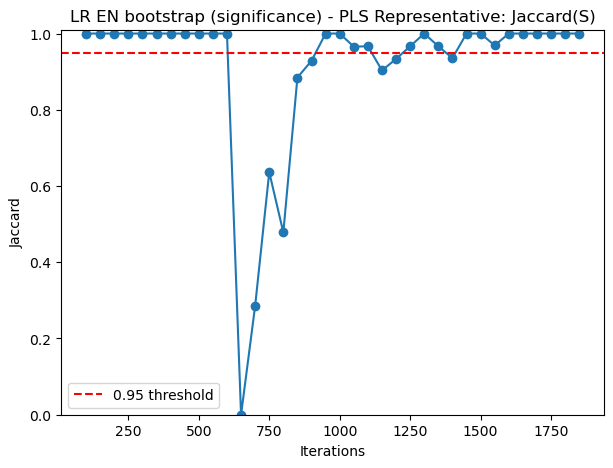

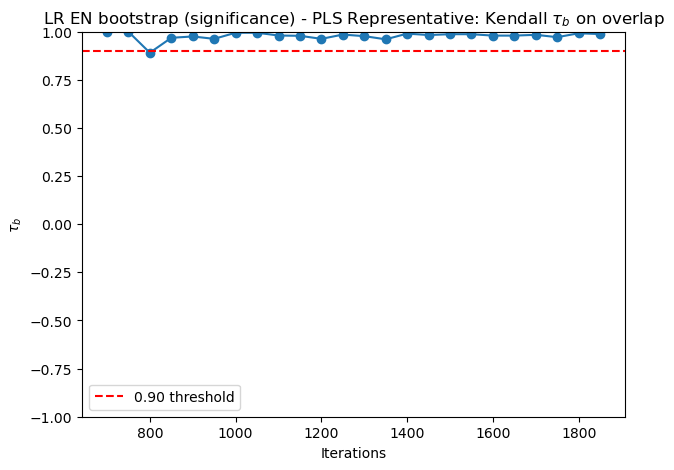

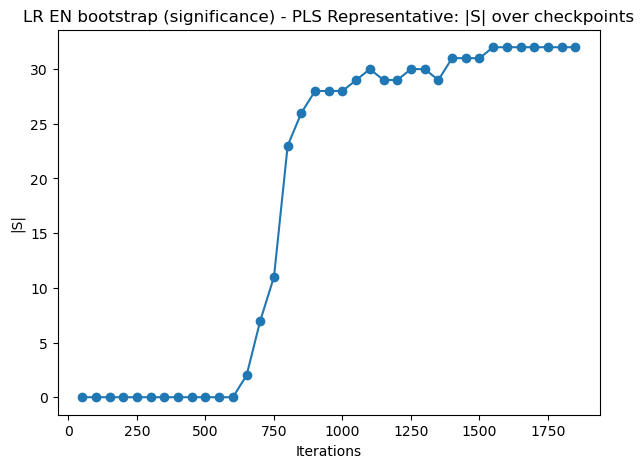

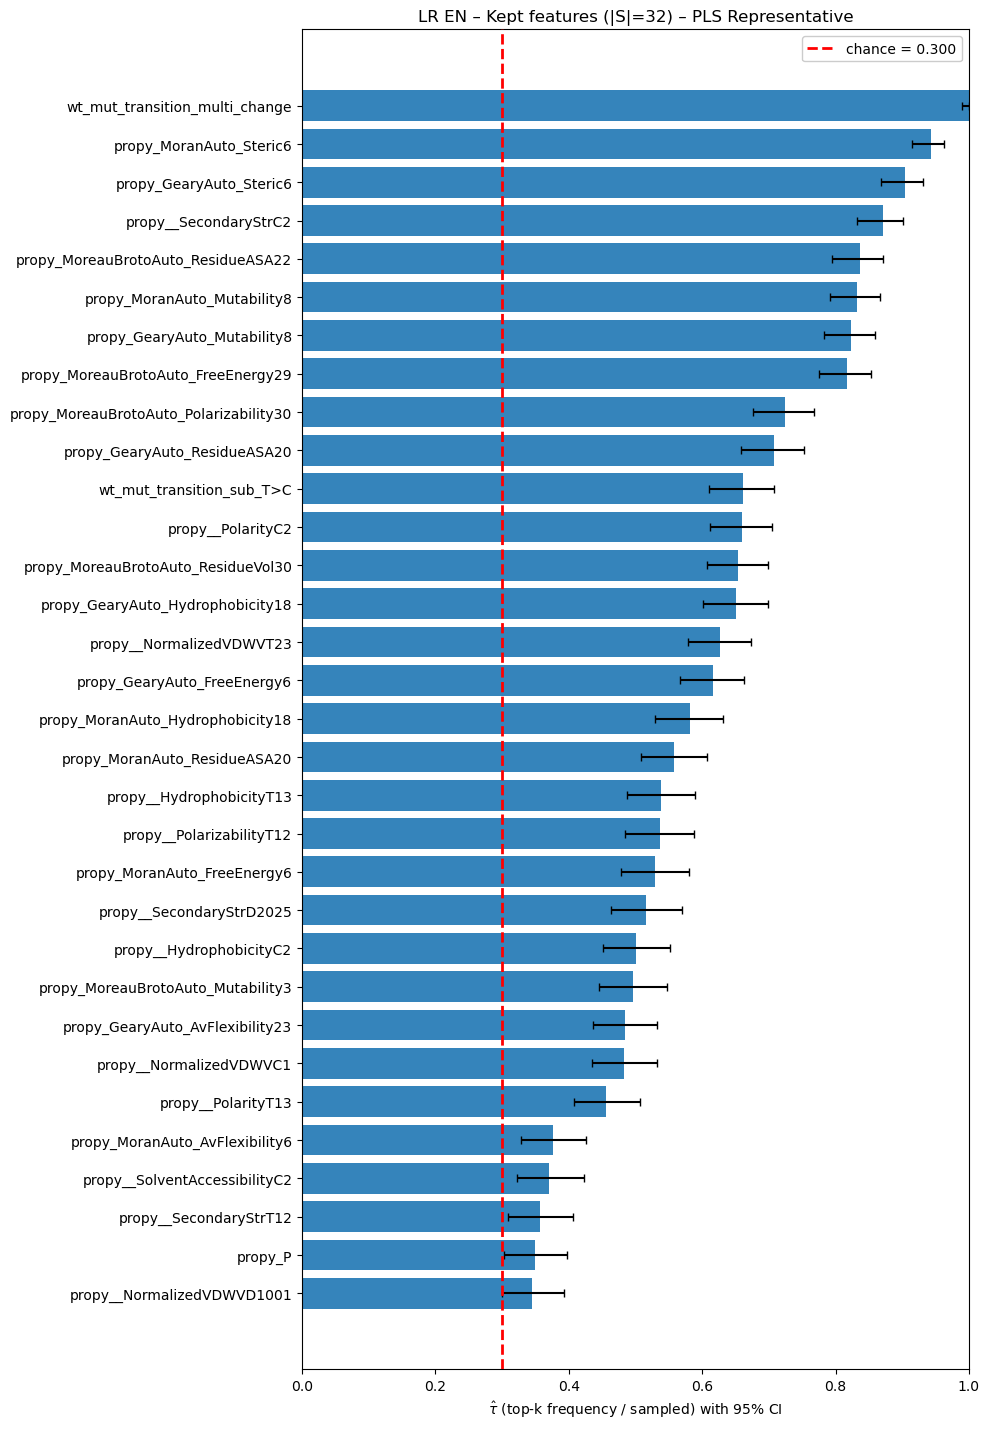

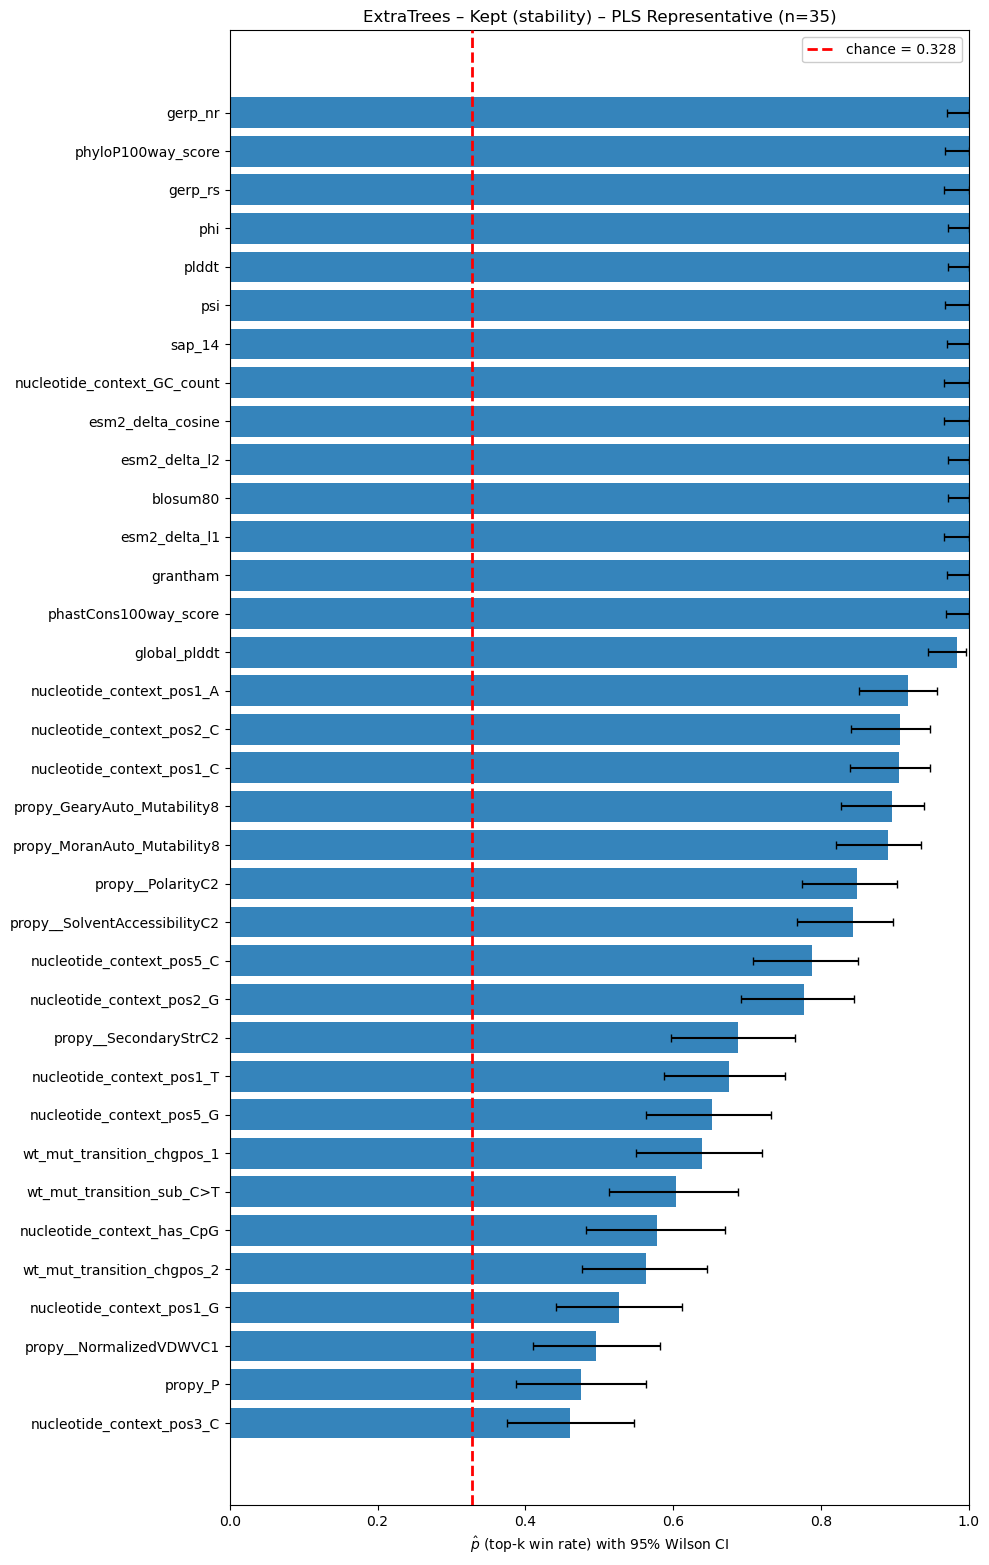

Validation AUC (permutation baseline): 0.821


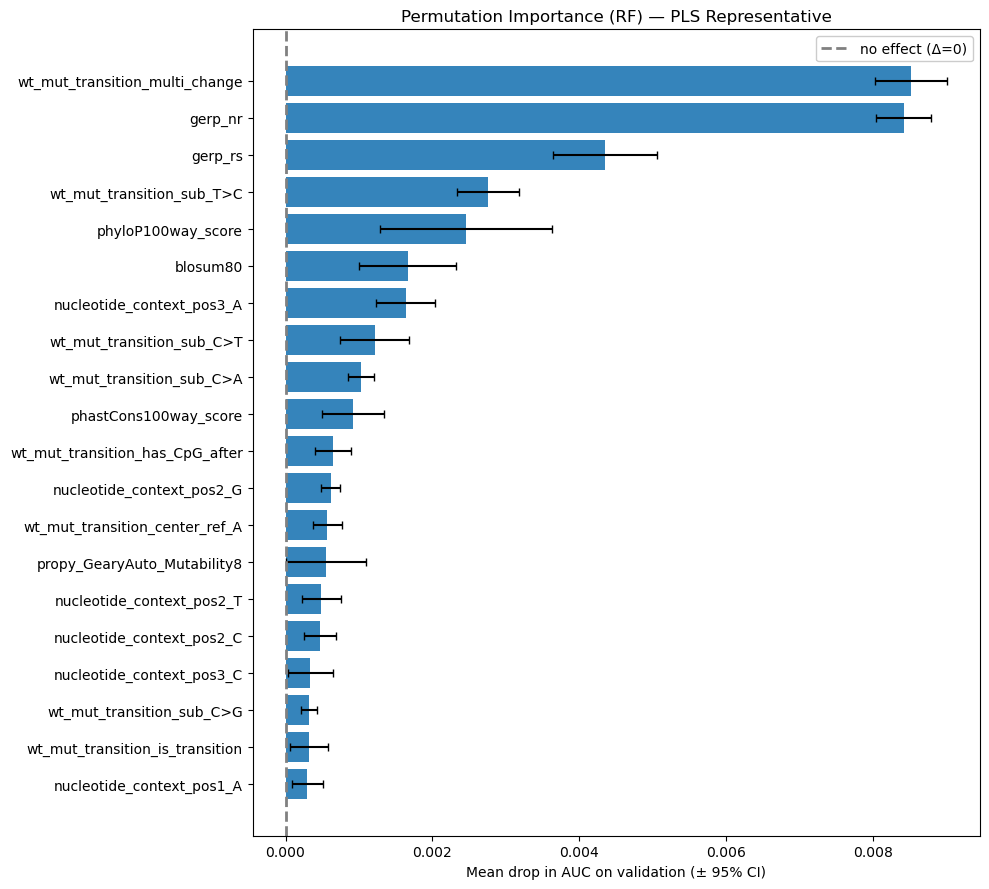

Validation AUC (LightGBM): 0.846


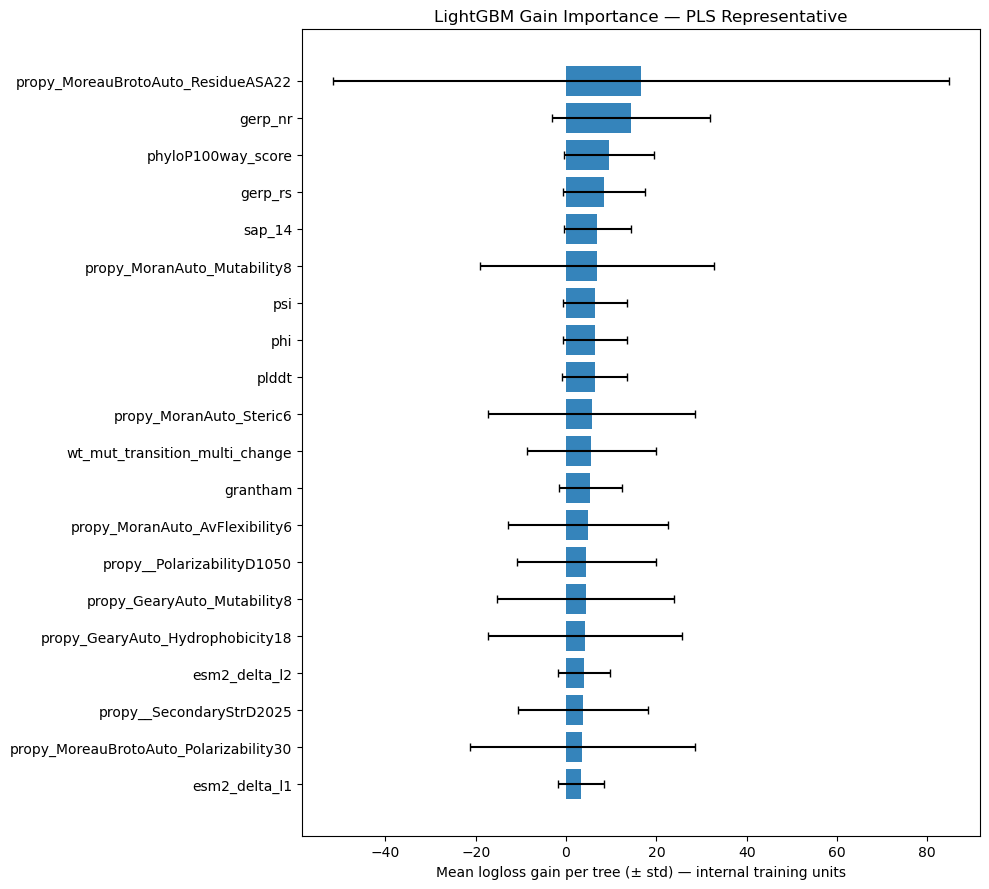

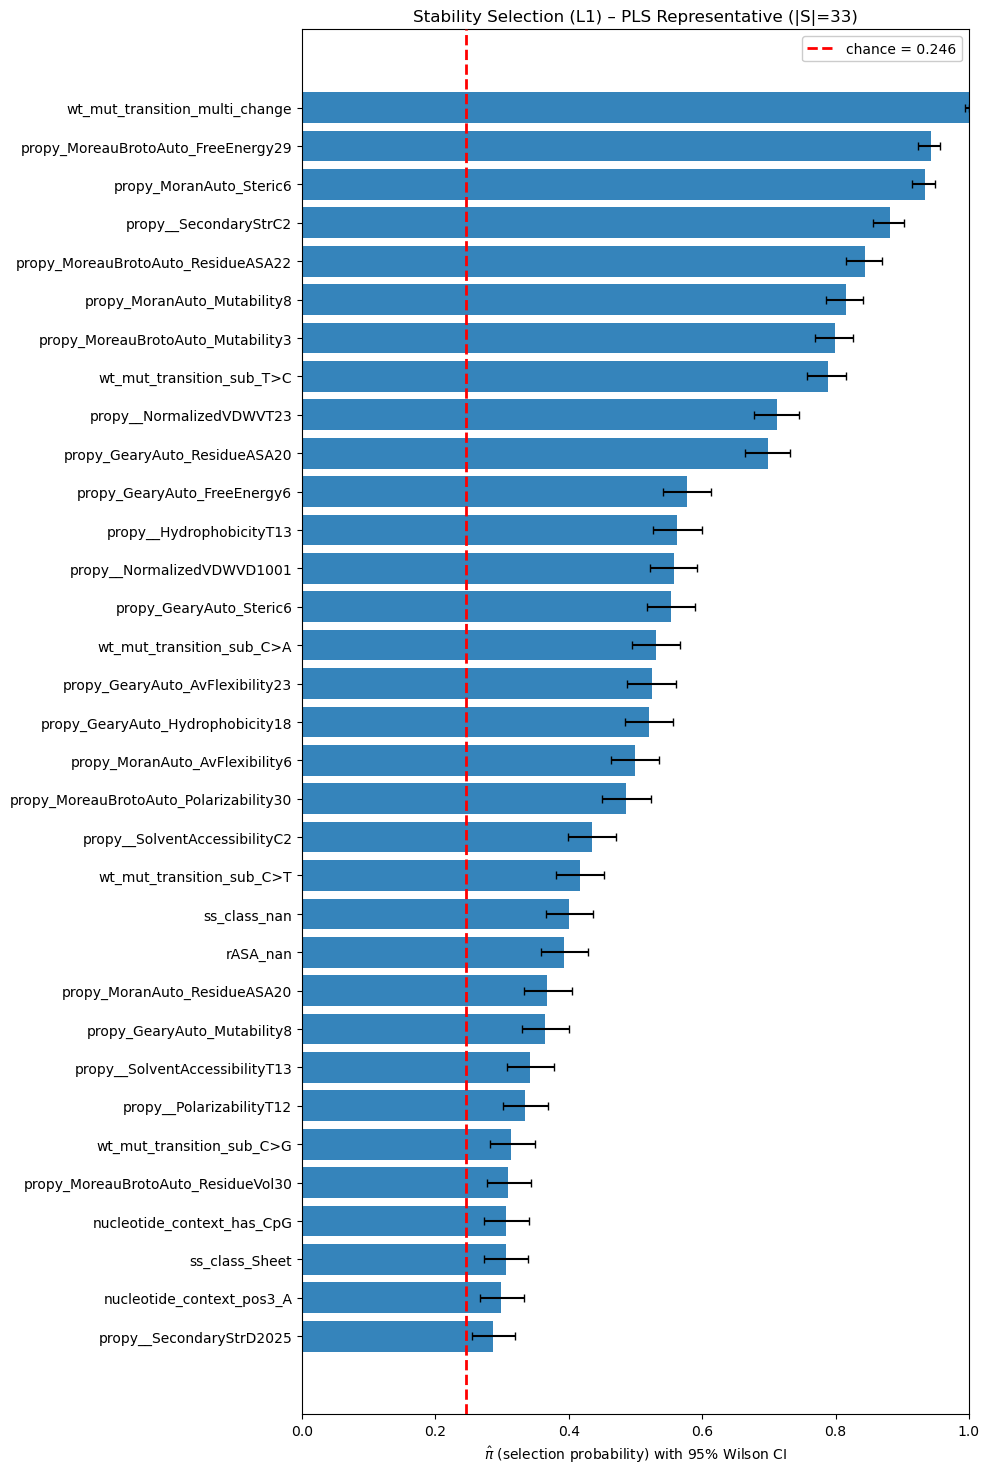

In [42]:
final_results = {}
for name, df_curr in datasets_to_test.items():
    experts, aux = run_all_experts_on(name, df_curr, y)
    consensus_feats, votes = vote_consensus(experts, min_votes=1)

    keep, pruned_df, pairs_df, corr_mat = corr_prune_with_report(
        df_curr,
        consensus_feats,
        thresh=0.90,
        aux=aux,
        votes=votes
    )

    final_results[name] = {
        'experts': experts,
        'consensus_raw': consensus_feats,
        'consensus_pruned': keep,
        'votes': votes,
        'aux': aux,
        'prune_report': pruned_df,
        'corr_pairs': pairs_df,
        'corr_matrix': corr_mat
    }

In [43]:
features_lr = final_results['PLS Representative']['experts']['lr_sig']
features_et = final_results['PLS Representative']['experts']['et_meanstd']
features_perm = final_results['PLS Representative']['experts']['perm_rf']
features_stab = final_results['PLS Representative']['experts']['stabsel']
features_lgbm = final_results['PLS Representative']['experts']['lgbm_gain']

In [44]:
print(len(features_lr))
print(len(features_et))
print(len(features_perm))
print(len(features_stab))
print(len(features_lgbm))

32
35
20
33
20


In [45]:
for name, res in final_results.items():
    print(f"\n=== {name} ===")
    print(f"Kept ({len(res['consensus_pruned'])}): {', '.join(res['consensus_pruned'])}")
    if res['prune_report'].empty:
        print("No features pruned by correlation.")
    else:
        print("\nPruned due to |corr| ≥ 0.90 (kept ▸ pruned : corr):")
        for _, r in res['prune_report'].iterrows():
            print(f"  {r['kept']} ▸ {r['pruned']} : {r['corr']:.3f}")

    print("\nTop correlated pairs overall:")
    print(res['corr_pairs'].head().to_string(index=False))


=== PLS Representative ===
Kept (56): wt_mut_transition_multi_change, propy_GearyAuto_Mutability8, wt_mut_transition_sub_T>C, propy_MoranAuto_Steric6, propy__SecondaryStrC2, phyloP100way_score, propy_MoreauBrotoAuto_Polarizability30, wt_mut_transition_sub_C>T, gerp_nr, gerp_rs, propy_GearyAuto_Hydrophobicity18, propy__SolventAccessibilityC2, propy_GearyAuto_FreeEnergy6, propy_MoranAuto_AvFlexibility6, wt_mut_transition_sub_C>A, blosum80, propy_GearyAuto_ResidueASA20, propy__SecondaryStrD2025, nucleotide_context_pos3_A, phastCons100way_score, propy__HydrophobicityT13, propy__NormalizedVDWVT23, propy_MoreauBrotoAuto_FreeEnergy29, propy__PolarizabilityT12, nucleotide_context_has_CpG, nucleotide_context_pos2_C, propy_GearyAuto_AvFlexibility23, propy__NormalizedVDWVD1001, propy_MoreauBrotoAuto_Mutability3, propy_P, esm2_delta_l2, wt_mut_transition_sub_C>G, nucleotide_context_pos2_G, phi, nucleotide_context_pos3_C, wt_mut_transition_has_CpG_after, plddt, grantham, nucleotide_context_pos1_A,

In [46]:
print("\n" + "="*80)
print("FINAL SUMMARY OF CONSENSUS SETS (corr prune @ 0.9)")
print("="*80)
for name, res in final_results.items():
    raw = res['consensus_raw']; pruned = res['consensus_pruned']
    print(f"\n--- {name} ---")
    print(f"Consensus (raw): {len(raw)} features")
    print(", ".join(raw[:40]) + ("..." if len(raw) > 40 else ""))
    print(f"Consensus (pruned): {len(pruned)} features")
    print(", ".join(pruned))


FINAL SUMMARY OF CONSENSUS SETS (corr prune @ 0.9)

--- PLS Representative ---
Consensus (raw): 72 features
wt_mut_transition_multi_change, propy_MoranAuto_Steric6, propy_GearyAuto_Steric6, propy__SecondaryStrC2, propy_MoreauBrotoAuto_ResidueASA22, propy_MoranAuto_Mutability8, propy_GearyAuto_Mutability8, propy_MoreauBrotoAuto_FreeEnergy29, propy_MoreauBrotoAuto_Polarizability30, propy_GearyAuto_ResidueASA20, wt_mut_transition_sub_T>C, propy__PolarityC2, propy_MoreauBrotoAuto_ResidueVol30, propy_GearyAuto_Hydrophobicity18, propy__NormalizedVDWVT23, propy_GearyAuto_FreeEnergy6, propy_MoranAuto_Hydrophobicity18, propy_MoranAuto_ResidueASA20, propy__HydrophobicityT13, propy__PolarizabilityT12, propy_MoranAuto_FreeEnergy6, propy__SecondaryStrD2025, propy__HydrophobicityC2, propy_MoreauBrotoAuto_Mutability3, propy_GearyAuto_AvFlexibility23, propy__NormalizedVDWVC1, propy__PolarityT13, propy_MoranAuto_AvFlexibility6, propy__SolventAccessibilityC2, propy__SecondaryStrT12, propy_P, propy__Nor

In [ ]:
from pathlib import Path

def _slug(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9]+', '_', s).strip('_').lower()

def save_selected_feature_sets(final_results, names=None, out_dir='feature_sets_large_study'):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    # If names is None -> save all datasets present
    if names is None:
        names = list(final_results.keys())
    elif isinstance(names, str):
        names = [names]  # accept a single string too

    saved = {}
    for name in names:
        if name not in final_results:
            print(f"{name!r} not found in final_results; skipping.")
            continue

        # prefer pruned, fall back to raw if missing
        keep = list(final_results[name].get('consensus_pruned', []))
        if not keep and 'consensus_raw' in final_results[name]:
            keep = list(final_results[name]['consensus_raw'])

        path = out_dir / f'{_slug(name)}_features.csv'
        pd.DataFrame({'feature': keep}).to_csv(path, index=False)
        saved[name] = str(path)

    return saved

In [ ]:
saved_lists = save_selected_feature_sets(final_results)